In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
import sys
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
import re

In [ ]:
!pip install openpyxl

In [ ]:
df = pd.read_csv('../input/pink-floyd-lyrics/pink_floyd_lyrics.csv')
pop = pd.read_excel('../input/pink-floyd-popularity-by-album/CSPCPinkFloydTotals-2.xlsx',header=0)
df.head()

In [ ]:
pop = pop.drop(['Unnamed: 5'],axis=1)
pop = pop[1:]
pop.rename(columns={"Unnamed: 1": "Year", 
                    "Full Length": "Full_Length_Studio_Album",
                    "Unnamed: 3": "Full_Length_Other_releases",
                   "Singles":"Singles_Physical",
                    "Unnamed: 6":"Singles_Digital",
                    "Unnamed: 7": "Singles_Streaming"}, errors="raise",inplace=True)

In [ ]:
df.info()

## pink floyd lyrics generator

In [ ]:
df['year'] = df['year'].apply(lambda x: int(x.split('-')[0]))
df.head()

In [ ]:
df.year.max()-df.year.min()

In [ ]:
plt.figure(figsize=(12,12),edgecolor='blue')
sns.countplot(x="year", data=df)

In [ ]:
pop

In [ ]:
pop['Total CSPC'] = [int(i.replace(' ','')) for i in pop['Total CSPC']]
pop['Year'] = [str(i) for i in pop['Year']]
pop = pop[:-1]

In [ ]:
plt.figure(figsize=(14, 8))
plt.xlabel('Year of Album Release',fontsize=12)
plt.ylabel('Total CSPC',fontsize=12)
plt.title("Pink Floyd's popularity wrt Time",fontsize=18)
plt.plot(pop['Year'],pop['Total CSPC'], color='blue', marker='o', markeredgecolor='green', markerfacecolor='red')
plt.savefig('pop_plot.jpeg')

In [ ]:
def count_lines(text):
  count,k,p=0,0,0
  for i in text.split('\n'):
    res = re.findall("[a-zA-Z’]+", i)
    if res:
      p+=1
      if len(res)>2:
        k+=1
        count+=len(res)
  if k!=0:
    mean = count/k
  else:
    mean = 2
  total = p
  big_lines = k
  small_lines = (p-k)
  
  return mean,total,big_lines,small_lines

cl = []
for j in range(0,len(df)):
  if type(df.lyrics.iloc[j])==str :
    m,t,bl,sl = count_lines(df.lyrics.iloc[j])
    year = int(df.year.iloc[j])
    if sl!=0:
      l = [m,t,bl,sl,bl/sl,year]
    else:
      l = [m,t,bl,sl,0,year]
    cl.append(l)

df_clines = pd.DataFrame(cl,columns=['mean_lines','total_lines','big_lines','small_lines','ratio_of_blsl','year'])
df_clines.head()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,7))
fig.suptitle('Testing Line count')

axs[0,0].hist(df_clines['mean_lines'],edgecolor='red')
axs[0,0].set_title('Mean Lines')
axs[0,1].hist(df_clines['total_lines'],edgecolor='red')
axs[0,1].set_title('Total Lines')
axs[1,0].hist(df_clines['big_lines'],edgecolor='red')
axs[1,0].set_title('Big Lines')
axs[1,1].hist(df_clines['ratio_of_blsl'],edgecolor='red')
axs[1,1].set_title('Ratio of Big/small lines')

In [ ]:
df_clines_gb = df_clines.groupby(['year']).mean()
df_clines_gb.reset_index(level=0, inplace=True)
df_clines_gb

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,10))
fig.suptitle('Testing Line count')

sns.barplot(ax=axs[0,0],x="year",y='mean_lines', data=df_clines_gb)
axs[0,0].set_title('Mean Words per Lines')
sns.barplot(ax=axs[0,1],x="year",y='total_lines', data=df_clines_gb)
axs[0,1].set_title('Total Lines')
sns.barplot(ax=axs[1,0],x="year",y='big_lines', data=df_clines_gb)
axs[1,0].set_title('Big Lines')
sns.barplot(ax=axs[1,1],x="year",y='ratio_of_blsl', data=df_clines_gb)
axs[1,1].set_title('Ratio of Big/small lines')


In [ ]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts([df.lyrics.iloc[1].replace('\n',' \n ')])
tokenizer.word_index

In [ ]:
text = df.lyrics.iloc[1].split('\n')
text = [re.sub(r'\d+', '', i) for i in text]
corpus = list(set(text))

In [ ]:
corpus

In [ ]:
lines=[]

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    print('--'*25)
    print(token_list)
    print('--'*25)
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        print(n_gram_sequence)

In [ ]:
def ngram(token_list):
  ng = []
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    ng.append(n_gram_sequence)
  return ng

In [ ]:
df.iloc[[0]].lyrics.iloc[0]

In [ ]:
def seqform(data):
  
  tokenise = Tokenizer()
  input_sequences = []
  corpus = []
  k=0

  for i in range(0,len(df)):
    
   text = df.iloc[[i]].lyrics.iloc[0]
   if type(text)==float:
     pass
   else:
     text = text.lower().split("\n")
     text = [re.sub(r'\d+', '', i) for i in text]
     text = list(set(text))
     if text==' ':
       pass
     else:
       corpus.extend(text)
     k+=1
  
  tokenise.fit_on_texts(corpus)
  for line in corpus:
    token_list = tokenise.texts_to_sequences([line])[0]
    input_sequences.extend(ngram(token_list))
 
  
  max_sequence_len = max([len(x) for x in input_sequences])
  input_sequences = np.array(pad_sequences(input_sequences,
                       maxlen = max_sequence_len, padding='pre'))
  
  predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
  fin_data = pd.DataFrame(np.hstack((predictors, label.reshape(-1,1))),columns=np.hstack((np.arange(1,predictors.shape[1]+1),np.array(['label']))))
  total_words = len(tokenise.word_index) + 1
  print('{} number of lyrics inputted'.format(k))

  return fin_data,tokenise,max_sequence_len,total_words,predictors,label
  

In [ ]:
fdf,tokenise,max_sequence_len,total_words,predictors,label = seqform(df)
print(fdf.shape,max_sequence_len,total_words)

In [ ]:
fdf.head(10)

In [ ]:
fdf .to_csv('fin_df.csv',index=False)

## LSTM

In [ ]:
print(fdf.shape)
print(fdf.values.max())

In [ ]:
dataX = [fdf.iloc[i,0:87].tolist() for i in range(0,fdf.shape[0])]
dataY = [fdf.iloc[i,87] for i in range(0,fdf.shape[0])]
print(len(dataX))
print(len(dataY))

In [ ]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (13839, 87, 1))

# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [ ]:
len(y[0])

In [ ]:
print(predictors.shape)
print(label.shape)
print(X.shape,y.shape)
print(total_words,max_sequence_len)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
# Add an LSTM Layer
model.add(Bidirectional(LSTM(150, return_sequences=True)))  
# A dropout layer for regularisation
model.add(Dropout(0.2))
# Add another LSTM Layer
model.add(LSTM(100)) 
model.add(Dense(total_words/2, activation='relu'))  
# In the last layer, the shape should be equal to the total number of words present in our corpus
model.add(Dense(y.shape[1], activation='softmax'))
#model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())

In [ ]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X,y, epochs= 60,callbacks=callbacks_list)
#model.fit(predictors, label, epochs=100, callbacks=callbacks_list)

In [ ]:
#37-4.9734
filename = "weights-improvement-50-0.8289.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')
model.fit(X, y, epochs=20, callbacks=callbacks_list)

In [ ]:
model.save_weights(Data_dir+'my_model_weights.h5')
model.save(Data_dir+'my_model.h5')

In [ ]:
model.save(Data_dir + 'saved_model/my_model')

In [ ]:
def make_lyrics(seed_text, next_words):
    pred_index=[]
    for i in range(next_words):
        token_list = tokenise.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        #print(token_list.shape)
        token_list = np.reshape(token_list, (1, max_sequence_len-1, 1))
        predicted = model.predict(token_list, verbose=0)
        predicted_index =  np.argmax(predicted)
        pred_index.append(predicted_index)
        


        #predicted_index=1
        output_word = ""
        for word, index in tokenise.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)
    return seed_text

In [ ]:
reverse_word_map = dict(map(reversed, tokenise.word_index.items()))
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
pattern_val = [i for i in pattern if i>0]
print("Seed:")
print(' '.join([reverse_word_map.get(value) for value in pattern_val]))
seed_text = [reverse_word_map.get(value)+' ' for value in pattern_val]

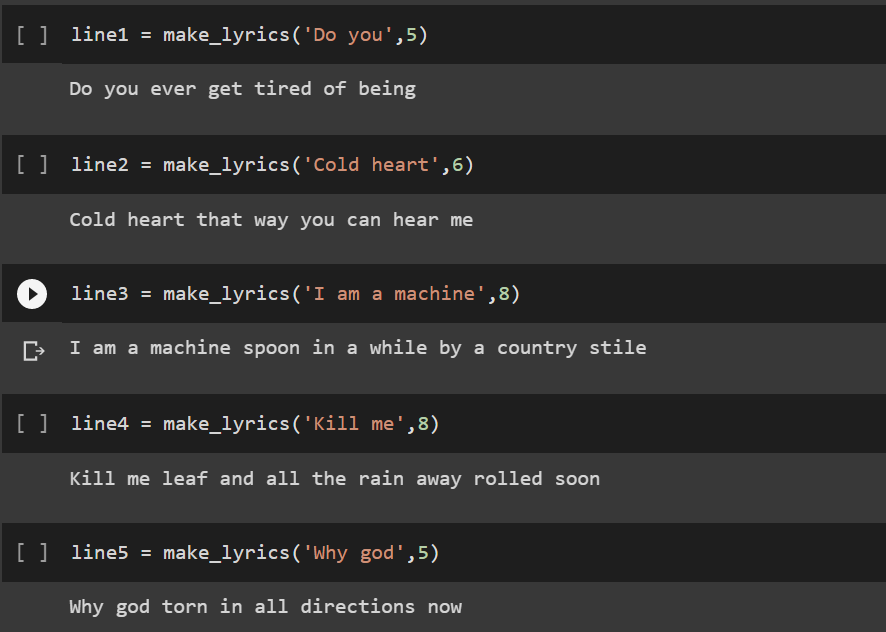

In [ ]:
import pickle

# saving
with open(Data_dir+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenise, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)